TODO: Clean dataloader.

# Tiny Stories Hackathon
> From Cluster of stars study group

## TinyStories Hackathon Rules
This hackathon is intended to be a fun competition to give ourselves practice pretraining LLMs on consumer hardware. We will follow the [TinyStories paper](<https://arxiv.org/abs/2305.07759>) and train small language models on small datasets and hardware.

The hackathon will end on April 7th, [AOE](<https://en.wikipedia.org/wiki/AoE>).

### Datasets
1. [**TinyStories:**](<https://huggingface.co/datasets/roneneldan/TinyStories>)
   Note that the TinyStories dataset is split into two versions both in the HF dataset:
     - GPT-3.5 generated TinyStories
    - GPT-4 generated TinyStories
   The tar file appears to have the cleanest versions with the least number of duplicates.
2. **[Simple Wikipedia](<https://huggingface.co/datasets/lsb/simplewiki2023>)** (optional)
   This dataset can be used to give your model more world knowledge than from just the TinyStories dataset. But be careful that 
it doesn't cause your model to use words which a typical 3 to 4-year-olds doesn't understand. It may need to be cleaned.

### Evaluation
Models will be evaluated by LLM-as-a-judge following the methodology outlined in the TinyStories paper. More details including how to submit your model's outputs early next week.

### Model Size Limits
Participants will be slotted into one of the following categories based on their hardware:
- **Small**: Up to 30M parameters. Low-to-mid range laptop GPUs and Apple Silicon.
- **Medium**: Up to 60M parameters. Mid-range GPUs (including high-end laptop GPUs and Apple Silicon)
- **Large**: Up to 120M parameters. High-end GPUs and multi-GPU systems.

### Tokenizers
While you must train your model from scratch, you are welcome to use any pre-trained tokenizer or train your own tokenizer.

### Model Architecture
You are welcome to use any model architecture you want provided you stay within the parameter budget of your hardware by following the parameter counting rules below.

### Parameter Counting
The Parameter budget is the number of unique floating-point weights receiving gradient updates:
- Unique Weights: Count each distinct floating-point weight stored in the model once.
- Reuse Multiplier: For each weight, multiply by the number of distinct times it contributes to forward computation (e.g., due to layer-sharing, layer reuse, or non-standard head-sharing). Weight-tied embedding and decoder weights are the exception and are only counted once. MQA/GQA doesn't count as head-sharing.

### Teams
Teams are limited to a maximum of 2 members and must be formed and declared within the first week.

### Training Frameworks
You might want to take a look at the following libraries and frameworks and adopt one for pretraining:
- [Composer](<https://docs.mosaicml.com/projects/composer/en/stable/index.html>) and optionally [LLM Foundry](<https://github.com/mosaicml/llm-foundry>)
- [PyTorch Lightning](<https://lightning.ai/docs/pytorch/stable/>) and optionally [LitGPT](<https://github.com/Lightning-AI/litgpt>)
- Hugging Face [Trainer](<https://huggingface.co/docs/transformers/en/main_classes/trainer>), [Accelerate](<https://huggingface.co/docs/accelerate/en/index>), and optionally [Axolotl](<https://axolotl-ai-cloud.github.io/axolotl/>) (a wrapper on top of HF)
- [fastai](<https://docs.fast.ai/>) with either [fastxtend](<https://fastxtend.benjaminwarner.dev/text.huggingface.html>)/[blurr](<https://ohmeow.github.io/blurr/>)

## Data

### Dataset (?)

In [ ]:
from datasets import load_dataset
import tiktoken
import torch

from minai import *

Grab tiny stories data from hugging face.

In [ ]:
ds = load_dataset('roneneldan/TinyStories')
trn = ds['train']
val = ds['validation']
trn

README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 2119719
})

In [ ]:
val

Dataset({
    features: ['text'],
    num_rows: 21990
})

For now, we can just use gpt2 tokenizer to get started.

In [ ]:
tokenizer = tiktoken.get_encoding('gpt2')

txt = trn[0]['text']
txt

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [ ]:
tokenizer.encode(txt)[:10]

[3198, 1110, 11, 257, 1310, 2576, 3706, 20037, 1043, 257]

In [ ]:
tokenizer.decode(tokenizer.encode(txt)[:10])

'One day, a little girl named Lily found a'

Let's encode them.

In [ ]:
def encode(b):
    b['text'] = [tokenizer.encode(o, allowed_special={'<|endoftext|>'}) for o in b['text']]
    return b

In [ ]:
ds = ds.with_transform(encode)
trn = ds['train']
val = ds['validation']
trn

Dataset({
    features: ['text'],
    num_rows: 2119719
})

Now we have numbers. We have to decode them to read text.

In [ ]:
trn[0]['text'][:5]

[3198, 1110, 11, 257, 1310]

In [ ]:
tokenizer.decode(trn[0]['text'])

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

### Chunk

Let's try to use very small subset of data to get started. Our goal is to add `eot_token` to the end of each text. Then, chop them up into `seq_len` to create each batch.

In [ ]:
seq_len = 256
chunk_sz = seq_len + 1
eot_token = 50256
eot_tensor = torch.tensor([eot_token])

div_by = 1000

In [ ]:
data_len = trn.num_rows // div_by // 3
data_len

706

In [ ]:
seq_tensor = [torch.tensor(o) for o in trn[:data_len]['text']]
seq_tensor[0]

tensor([ 3198,  1110,    11,   257,  1310,  2576,  3706, 20037,  1043,   257,
        17598,   287,   607,  2119,    13,  1375,  2993,   340,   373,  2408,
          284,   711,   351,   340,   780,   340,   373,  7786,    13, 20037,
         2227,   284,  2648,   262, 17598,   351,   607,  1995,    11,   523,
          673,   714, 34249,   257,  4936,   319,   607, 10147,    13,   198,
          198,    43,   813,  1816,   284,   607,  1995,   290,   531,    11,
          366, 29252,    11,   314,  1043,   428, 17598,    13,  1680,   345,
         2648,   340,   351,   502,   290, 34249,   616, 10147,  1701,  2332,
         1995, 13541,   290,   531,    11,   366,  5297,    11, 20037,    11,
          356,   460,  2648,   262, 17598,   290,  4259,   534, 10147,   526,
          198,   198, 41631,    11,   484,  4888,   262, 17598,   290,   384,
        19103,   262,  4936,   319, 20037,   338, 10147,    13,   632,   373,
          407,  2408,   329,   606,   780,   484,   547,  7373, 

In [ ]:
cat = torch.cat([torch.cat([s, eot_tensor]) for s in seq_tensor])
cat[:200]

tensor([ 3198,  1110,    11,   257,  1310,  2576,  3706, 20037,  1043,   257,
        17598,   287,   607,  2119,    13,  1375,  2993,   340,   373,  2408,
          284,   711,   351,   340,   780,   340,   373,  7786,    13, 20037,
         2227,   284,  2648,   262, 17598,   351,   607,  1995,    11,   523,
          673,   714, 34249,   257,  4936,   319,   607, 10147,    13,   198,
          198,    43,   813,  1816,   284,   607,  1995,   290,   531,    11,
          366, 29252,    11,   314,  1043,   428, 17598,    13,  1680,   345,
         2648,   340,   351,   502,   290, 34249,   616, 10147,  1701,  2332,
         1995, 13541,   290,   531,    11,   366,  5297,    11, 20037,    11,
          356,   460,  2648,   262, 17598,   290,  4259,   534, 10147,   526,
          198,   198, 41631,    11,   484,  4888,   262, 17598,   290,   384,
        19103,   262,  4936,   319, 20037,   338, 10147,    13,   632,   373,
          407,  2408,   329,   606,   780,   484,   547,  7373, 

In [ ]:
cat.shape

torch.Size([135959])

Let's create batches with `seq_length`.

In [ ]:
num_complete_segments = cat.size(0) // chunk_sz
num_complete_segments

529

In [ ]:
complete_segments = cat[:num_complete_segments * chunk_sz].view(-1, chunk_sz)
complete_segments.shape

torch.Size([529, 257])

> TODO

Looking at the last bit, it is pretty close to a whole `seq_len`. We can pad it and use it later.

In [ ]:
remainder = cat[num_complete_segments * seq_len:]
remainder.shape

torch.Size([535])

### Dataset (!)

Let's create inputs and targets for a dataset.

In [ ]:
inps = complete_segments[:, :-1]
targs = complete_segments[:, 1:]
inps.shape, targs.shape

(torch.Size([529, 256]), torch.Size([529, 256]))

In [ ]:
inps[0][:20]

tensor([ 3198,  1110,    11,   257,  1310,  2576,  3706, 20037,  1043,   257,
        17598,   287,   607,  2119,    13,  1375,  2993,   340,   373,  2408])

In [ ]:
targs[0][:20]

tensor([ 1110,    11,   257,  1310,  2576,  3706, 20037,  1043,   257, 17598,
          287,   607,  2119,    13,  1375,  2993,   340,   373,  2408,   284])

We can create a dataset now.

In [ ]:
trn_ds = Dataset(inps, targs)
trn_ds[0]

(tensor([ 3198,  1110,    11,   257,  1310,  2576,  3706, 20037,  1043,   257,
         17598,   287,   607,  2119,    13,  1375,  2993,   340,   373,  2408,
           284,   711,   351,   340,   780,   340,   373,  7786,    13, 20037,
          2227,   284,  2648,   262, 17598,   351,   607,  1995,    11,   523,
           673,   714, 34249,   257,  4936,   319,   607, 10147,    13,   198,
           198,    43,   813,  1816,   284,   607,  1995,   290,   531,    11,
           366, 29252,    11,   314,  1043,   428, 17598,    13,  1680,   345,
          2648,   340,   351,   502,   290, 34249,   616, 10147,  1701,  2332,
          1995, 13541,   290,   531,    11,   366,  5297,    11, 20037,    11,
           356,   460,  2648,   262, 17598,   290,  4259,   534, 10147,   526,
           198,   198, 41631,    11,   484,  4888,   262, 17598,   290,   384,
         19103,   262,  4936,   319, 20037,   338, 10147,    13,   632,   373,
           407,  2408,   329,   606,   780,   484,  

We got the training dataset. Now, we can get the validation dataset with the same approach.

In [ ]:
val_data_len = val.num_rows // div_by * 10
val_data_len

210

In [ ]:
val_seq_tensor = [torch.tensor(o) for o in val[:val_data_len]['text']]
val_seq_tensor[0]

tensor([32565,    13, 15899,  2497,   262, 22441,  1097,   290,   531,    11,
          366, 22017,    11, 21168,    11,   534,  1097,   318,   523,  6016,
          290,  3424,  2474, 21168, 13541,   290,  8712,    11,   366, 10449,
          345,    11, 15899,    13,   314, 25245,   340,   790,  1110,   526,
          198,   198,  3260,  2712,   351,   262,  1097,    11, 21168,   290,
        15899,  2936, 47124,    13,  1119,  1043,   257,  1402, 16723,   351,
         1598,  1660,    13,  1119, 24070,   262,  1660,   290,  2936,   845,
         3772,    13,  1119,  2826,  1978,   477,  1110,   290,  2627,  1266,
         2460,    13])

In [ ]:
val_cat = torch.cat([torch.cat([s, eot_tensor]) for s in val_seq_tensor])
val_cat[:200]

tensor([32565,    13, 15899,  2497,   262, 22441,  1097,   290,   531,    11,
          366, 22017,    11, 21168,    11,   534,  1097,   318,   523,  6016,
          290,  3424,  2474, 21168, 13541,   290,  8712,    11,   366, 10449,
          345,    11, 15899,    13,   314, 25245,   340,   790,  1110,   526,
          198,   198,  3260,  2712,   351,   262,  1097,    11, 21168,   290,
        15899,  2936, 47124,    13,  1119,  1043,   257,  1402, 16723,   351,
         1598,  1660,    13,  1119, 24070,   262,  1660,   290,  2936,   845,
         3772,    13,  1119,  2826,  1978,   477,  1110,   290,  2627,  1266,
         2460,    13, 50256,  7454,  2402,   257,   640,    11,   287,   257,
         1263,  8222,    11,   612,  5615,   257,  9529,   259,   420, 27498,
         3706,   371, 23536,    13,   371, 23536,  6151,   284, 12080,    13,
         1375, 19952,  7150,    11, 12586,    11,   290, 18639,    13,  1881,
         1110,    11,   371, 23536,  1043,   281, 30284, 12788, 

In [ ]:
val_num_complete_segments = val_cat.size(0) // chunk_sz
val_num_complete_segments

167

In [ ]:
val_complete_segments = val_cat[:val_num_complete_segments * chunk_sz].view(-1, chunk_sz)
val_complete_segments.shape

torch.Size([167, 257])

In [ ]:
val_inps = val_complete_segments[:, :-1]
val_targs = val_complete_segments[:, 1:]
val_inps.shape, val_targs.shape

(torch.Size([167, 256]), torch.Size([167, 256]))

In [ ]:
val_ds = Dataset(val_inps, val_targs)
val_ds[0]

(tensor([32565,    13, 15899,  2497,   262, 22441,  1097,   290,   531,    11,
           366, 22017,    11, 21168,    11,   534,  1097,   318,   523,  6016,
           290,  3424,  2474, 21168, 13541,   290,  8712,    11,   366, 10449,
           345,    11, 15899,    13,   314, 25245,   340,   790,  1110,   526,
           198,   198,  3260,  2712,   351,   262,  1097,    11, 21168,   290,
         15899,  2936, 47124,    13,  1119,  1043,   257,  1402, 16723,   351,
          1598,  1660,    13,  1119, 24070,   262,  1660,   290,  2936,   845,
          3772,    13,  1119,  2826,  1978,   477,  1110,   290,  2627,  1266,
          2460,    13, 50256,  7454,  2402,   257,   640,    11,   287,   257,
          1263,  8222,    11,   612,  5615,   257,  9529,   259,   420, 27498,
          3706,   371, 23536,    13,   371, 23536,  6151,   284, 12080,    13,
          1375, 19952,  7150,    11, 12586,    11,   290, 18639,    13,  1881,
          1110,    11,   371, 23536,  1043,   281, 3

### DataLoader

We need a dataloader with the batch size.

TODO: do `drop_last=True` for training dataloader.

In [ ]:
bs = 4

trn_dl, val_dl = get_dls(trn_ds, val_ds, bs)
dls = DataLoaders(trn_dl, val_dl)
xb,yb = next(iter(trn_dl))
xb.shape,yb.shape

(torch.Size([4, 256]), torch.Size([4, 256]))

In [ ]:
xb[:5], yb[:5]

(tensor([[  835,   284, 14936,  ...,   262,  6729,   287],
         [  198,   464,  1310,  ...,   477,   262,   661],
         [16218,   287,  2263,  ...,   766,   644,   550],
         [ 2576,  2936,   517,  ...,  1869,   373, 14720]]),
 tensor([[  284, 14936,    30,  ...,  6729,   287,   257],
         [  464,  1310,  2576,  ...,   262,   661,  1088],
         [  287,  2263,  1337,  ...,   644,   550,   925],
         [ 2936,   517,  6776,  ...,   373, 14720,   290]]))

## Model

We make the model using transformer.

In [ ]:
import torch.nn as nn

### MultiHeadAttention

Here's the `MultiHeadAttention` with Causal attention.

In [ ]:
set_seed(42)
x = torch.randn((2, 2, 3)) # (bs, ctx_len, d_in)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, ctx_len, n_head, qkv_bias=False):
        super().__init__()
        assert (d_out % n_head == 0), "d_out must be divisible by num_heads"
        self.n_head = n_head
        self.d_in = d_in
        self.d_out = d_out
        self.head_dim = d_out // n_head
        self.w_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.register_buffer("mask", torch.triu(torch.ones((ctx_len, ctx_len)), diagonal=1).bool())
    
    def forward(self, x): 
        bs, num_tokens, d_in = x.shape
        q = self.w_q(x)  # (bs, num_tokens, d_out)
        k = self.w_k(x)
        v = self.w_v(x)
        
        q = q.view(bs, num_tokens, self.n_head, self.head_dim)  # (bs, num_tokens, n_head, head_dim)
        k = k.view(bs, num_tokens, self.n_head, self.head_dim)
        v = v.view(bs, num_tokens, self.n_head, self.head_dim)
        
        q = q.transpose(1,2) # (bs, n_head, num_tokens, head_dim)
        k = k.transpose(1,2)
        v = v.transpose(1,2)
        
        attn_scr = q@k.transpose(2,3) # (bs, n_head, num_tokens, num_tokens)
        attn_scr = attn_scr.masked_fill(self.mask[:num_tokens, :num_tokens], -torch.inf)
        attn_wt = torch.softmax(attn_scr / k.shape[-1]**0.5, -1)
        
        ctx_vec = attn_wt@v  # (bs, n_head, num_tokens, head_dim)
        ctx_vec = ctx_vec.transpose(1,2).reshape(bs, num_tokens, -1) # (bs, num_tokens, d_out)
        
        # concat
        return ctx_vec

In [ ]:
mha = MultiHeadAttention(d_in=3, d_out=4, ctx_len=2, n_head=2)
mha(x), mha(x).shape  # Outputs (bs, num_tokens, d_out)

(tensor([[[-0.0806, -0.0211,  0.1296, -0.0414],
          [ 0.2287,  0.1592, -0.0296, -0.1997]],
 
         [[ 0.6081,  0.0087,  0.2989, -0.4998],
          [ 0.1026,  0.0422,  0.3105, -0.2781]]], grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 2, 4]))

### FeedForward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, act=nn.ReLU()):
        super().__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.act = act
        self.l2 = nn.Linear(hidden_dim, in_dim)
    
    def forward(self, x):
        return self.l2(self.act(self.l1(x)))

In [ ]:
set_seed(42)
x = torch.randn(4)
ff = FeedForward(4, 4*4)
ff(x), ff(x).shape

(tensor([-0.2928, -0.1471,  0.0123, -0.2592], grad_fn=<ViewBackward0>),
 torch.Size([4]))

### Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, ctx_len, n_head, drop_out=0, ff_mult=4, qkv_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.mha = MultiHeadAttention(emb_dim, emb_dim, ctx_len, n_head, qkv_bias=qkv_bias)
        self.do = nn.Dropout(drop_out)
        self.ff = FeedForward(emb_dim, emb_dim*ff_mult)
    
    def forward(self, x):
        skip1 = x
        x = self.ln1(x)
        x = self.mha(x)
        x = self.do(x)
        x = x + skip1
        
        skip2 = x
        x = self.ln2(x)
        x = self.ff(x)
        x = self.do(x)
        x = x + skip2
        return x

In [ ]:
set_seed(42)
x = torch.randn((2, 2, 3)) # (bs, ctx_len, d_in)
tb = TransformerBlock(emb_dim=3, ctx_len=2, n_head=1)
tb(x), tb(x).shape

(tensor([[[-0.3595, -1.0631,  0.5676],
          [-0.3159, -2.2222,  0.1778]],
 
         [[ 1.7169, -1.7565,  1.2721],
          [-0.3908, -0.2502,  0.3274]]], grad_fn=<AddBackward0>),
 torch.Size([2, 2, 3]))

### GPT model

In [ ]:
cfg = {
    'n_tb': 1,    # num transformer blocks
    'vocab_sz': 50257,
    'emb_dim': 48,
    'ctx_len': seq_len,
    'n_head': 1,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 4,
    'qkv_bias': False,
     }

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.do = nn.Dropout(cfg['drop_out'])
        self.tb = nn.Sequential(
            *[TransformerBlock(cfg['emb_dim'], cfg['ctx_len'], cfg['n_head'], cfg['drop_out_tb'],
                              cfg['ff_mult'], cfg['qkv_bias']) for _ in range(cfg['n_tb'])])
        self.final_ln = nn.LayerNorm(cfg['emb_dim'])
        self.final_l  = nn.Linear(cfg['emb_dim'], cfg['vocab_sz'])
    
    def forward(self, x):
        bs, seq_len = x.shape
        tok = self.token_emb(x)
        pos = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = self.do(tok + pos)
        x = self.tb(x)
        x = self.final_ln(x)
        x = self.final_l(x)
        return x

In [ ]:
batch = xb[:3]
batch.shape

torch.Size([3, 256])

In [ ]:
set_seed(42)
model = GPTModel(cfg)
logits = model(batch)
logits.shape

torch.Size([3, 256, 50257])

In [ ]:
def get_total_params(model): return sum(p.numel() for p in model.parameters())
total_params = get_total_params(model)

In [ ]:
model.token_emb.weight.shape, model.final_l.weight.shape

(torch.Size([50257, 48]), torch.Size([50257, 48]))

In [ ]:
def get_total_memory(model):
    total_params = get_total_params(model)
    total_size_bytes = total_params * 4   # Assuming fp32
    # Convert to megabytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    print(f"Total params: {total_params:,}")
    print(f"Total size: {total_size_mb:.2f} MB")

get_total_memory(model)

Total params: 7,313,137
Total size: 27.90 MB


### Text generation

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Crop current context if it exceeds the supported context size
        with torch.no_grad(): logits = model(idx_cond)         # (bs, n_tokens, vocab_sz)
        logits = logits[:, -1, :]                              # (bs, vocab_sz)
        probas = torch.softmax(logits, dim=-1)                 # (bs, vocab_sz)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (bs, 1)
        idx = torch.cat((idx, idx_next), dim=1)                # (bs, n_tokens+1)
    return idx

In [ ]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=cfg["ctx_len"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 38213, 23676,  9929, 29854,  3414, 22988]])
Output length: 10


In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Moves Poor overt DV announcedpeace


For convenience, we create functions.

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

In [ ]:
text_to_token_ids('wassup my dawg', tokenizer)

tensor([[ 86, 562, 929, 616, 288, 707,  70]])

In [ ]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
token_ids_to_text(text_to_token_ids('wassup my dawg', tokenizer), tokenizer)

'wassup my dawg'

In [ ]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=cfg["ctx_len"]
)

token_ids_to_text(token_ids, tokenizer)

'Every effort moves you589bj cartoon regional Islamabad Experimental Cancer straw unin fucked'

Sanity check

In [ ]:
print("Train loader:")
for x, y in trn_dl:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_dl:
    print(x.shape, y.shape)

Train loader:
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256])

In [ ]:
train_tokens = 0
for input_batch, target_batch in trn_dl:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_dl:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 135424
Validation tokens: 42752
All tokens: 178176


In [ ]:
# def calc_loss_batch(input_batch, target_batch, model, device):
#     input_batch, target_batch = input_batch.to(device), target_batch.to(device)
#     logits = model(input_batch)
#     loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
#     return loss


# def calc_loss_loader(data_loader, model, device, num_batches=None):
#     total_loss = 0.
#     if len(data_loader) == 0:
#         return float("nan")
#     elif num_batches is None:
#         num_batches = len(data_loader)
#     else:
#         # Reduce the number of batches to match the total number of batches in the data loader
#         # if num_batches exceeds the number of batches in the data loader
#         num_batches = min(num_batches, len(data_loader))
#     for i, (input_batch, target_batch) in enumerate(data_loader):
#         if i < num_batches:
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             total_loss += loss.item()
#         else:
#             break
#     return total_loss / num_batches

In [ ]:
import torch.nn.functional as F

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Note:
# # Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# # which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# # However, the resulting loss values may be slightly different.

# #if torch.cuda.is_available():
# #    device = torch.device("cuda")
# #elif torch.backends.mps.is_available():
# #    device = torch.device("mps")
# #else:
# #    device = torch.device("cpu")
# #
# # print(f"Using {device} device.")


# model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


# torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

# with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
#     train_loss = calc_loss_loader(trn_dl, model, device)
#     val_loss = calc_loss_loader(val_dl, model, device)

# print("Training loss:", train_loss)
# print("Validation loss:", val_loss)

## Learner

In [ ]:
from torcheval.metrics import  MulticlassAccuracy

In [ ]:
def loss_fn(pred, targ): return F.cross_entropy(pred.flatten(0, 1), targ.flatten())

In [ ]:
cfg = {
    'n_tb': 4,    # num transformer blocks
    'vocab_sz': 50257,
    'emb_dim': 96*2,
    'ctx_len': seq_len,
    'n_head': 4,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 4,
    'qkv_bias': False,
}

In [ ]:
set_seed(42)
model = GPTModel(cfg)
start_context = "Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=cfg["ctx_len"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could davidjl alliesopter mishand Free asteroidsBFatmeal lifes Definitive


In [ ]:
class LLMMetricsCB(MetricsCB):
    def __init__(self, *ms, **metrics):
        super().__init__(*ms, **metrics)
    
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds.flatten(0, 1)), y.flatten())
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(), TrainCB(), DeviceCB()]
learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs)
learn.summary()

Tot params: 30,627,601; MFLOPS: 30.6


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Embedding|(4, 256)|(4, 256, 192)|9,649,344|9.6|
|Embedding|(256,)|(256, 192)|9,649,344|9.6|
|Dropout|(4, 256, 192)|(4, 256, 192)|0|0.0|
|Sequential|(4, 256, 192)|(4, 256, 192)|1,628,928|1.6|
|LayerNorm|(4, 256, 192)|(4, 256, 192)|384|0.0|
|Linear|(4, 256, 192)|(4, 256, 50257)|9,699,601|9.7|


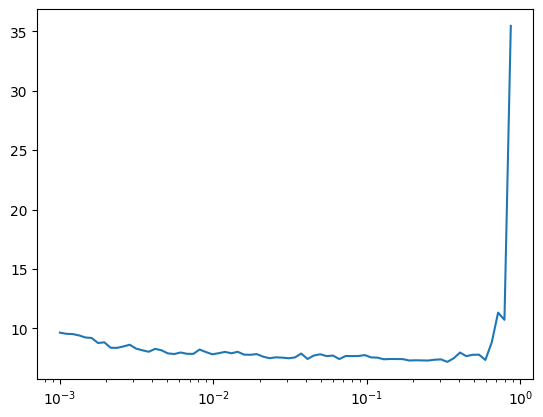

In [ ]:
learn.lr_find(gamma=1.1, max_mult=2, start_lr=1e-3)

In [ ]:
set_seed(42)
model = GPTModel(cfg)
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(), TrainCB(), DeviceCB()]
learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs)
learn.fit(10, lr=0.1)

accuracy,loss,epoch,train,time
0.097,7.704,0,train,00:16
0.080,6.733,0,eval,00:04
0.131,6.372,1,train,00:16
0.150,6.080,1,eval,00:04
0.153,5.940,2,train,00:16
0.144,5.835,2,eval,00:04
0.164,5.675,3,train,00:16
0.167,5.576,3,eval,00:04
0.171,5.485,4,train,00:17
0.178,5.436,4,eval,00:04


In [ ]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=cfg["ctx_len"])

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('evaluation_prompts.csv')
df.head()

,prompt,completion
0,"Once upon a time, there lived a bunny in a fie...",NaN
1,"Once upon a time, there lived a bunny in a fie...",NaN
2,"Once upon a time, there lived a bunny in a fie...",NaN
3,"Once upon a time, there lived a bunny in a fie...",NaN
4,"Once upon a time, there lived a bunny in a fie...",NaN


In [ ]:
df.iloc[0]['prompt']

"Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could"

In [ ]:
df.iloc[5]['prompt']

'One day a girl walked into the living room and noticed something very strange. There was a huge cabinet standing in the corner. It looked very old and heavy. She walked over and tried to open it, when suddenly'

In [ ]:
df.iloc[9]['prompt']

'One day a girl walked into the living room and noticed something very strange. There was a huge cabinet standing in the corner. It looked very old and heavy. She walked over and tried to open it, when suddenly'

In [ ]:
df.iloc[10]['prompt']

"Once upon a time, there lived a hamster in the forest. Every day, he would walked around the forest and looking for adventures. One day, he heard someone calling out from behind the bushes.\nThe hamster listened carefully. He realised that it was a small mouse calling out for help. It got stuck under a heavy log and couldn't get out. The hamster immediately realized that"

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:].to(device)
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could", tokenizer),
    max_new_tokens=150,
    context_size=cfg["ctx_len"],
    top_k=25,
    temperature=1.3
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

NameError: name 'device' is not defined

In [ ]:
prompt = df.loc[0, 'prompt']
prompt

"Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could"

In [ ]:
toks = text_to_token_ids(prompt, tokenizer)
toks

tensor([[ 7454,  2402,   257,   640,    11,   612,  5615,   257, 44915,   287,
           257,  2214,    13,  2332,  1438,   373, 22162,    13, 22162,  6151,
           284,   423,   730,  5773,   290,  4671,   351,   607, 44915,  2460,
            13,  1881,  1110,    11,   618, 22162,   373,   546,   284,  2666,
           329,   257, 26951,   379,   257,  1545,   338,  2156,    11,   673,
          6939,   673,   338,  3599,   284,  1254,  6639,    13,  1375,   373,
           523,  4939,   673,   714]])

In [ ]:
token_ids = generate(
    model=model,
    idx=toks,
    max_new_tokens=150,
    context_size=cfg["ctx_len"],
    top_k=25,
    temperature=1.3
)
token_ids

tensor([[ 7454,  2402,   257,   640,    11,   612,  5615,   257, 44915,   287,
           257,  2214,    13,  2332,  1438,   373, 22162,    13, 22162,  6151,
           284,   423,   730,  5773,   290,  4671,   351,   607, 44915,  2460,
            13,  1881,  1110,    11,   618, 22162,   373,   546,   284,  2666,
           329,   257, 26951,   379,   257,  1545,   338,  2156,    11,   673,
          6939,   673,   338,  3599,   284,  1254,  6639,    13,  1375,   373,
           523,  4939,   673,   714,   262,  4252,  2474,   198,  1537,   511,
         22940, 26391,  8151,  2474,   198,   464,  2576,   351,   465, 13373,
            11,   484,  2936,  1165,  1110,   607,  1995,   531,    13,   383,
          1641,   373,   407,   262,  1310,  2933,  3706,    13,  1375,  2497,
           607,  1995,   290,   340,   284,   307,   257,   845,  2041,   788,
           262,  3952,   290,   531,   262,  1310,  2576,  1110,   290,   339,
           531,   366,    40,   284,   423,   845,  

In [ ]:
print(token_ids_to_text(token_ids, tokenizer))

Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could the sun!"
But theirâ€™!"
The girl with his toy, they felt too day her mom said. The family was not the little boy named. She saw her mom and it to be a very special then the park and said the little girl day and he said "I to have very much and she heard a little girl got, � was a time of for her mom said and said the bug day, the forest!â€œ her way the garden, "It special, and said, � he would careful from the house she. "Mom and said she said, "I old a very saw a long help the old was to his a very was so excited to find!" She looked at the little boy went


In [ ]:
toks.shape

torch.Size([1, 64])

In [ ]:
print(token_ids_to_text(token_ids[:, toks.shape[1]:], tokenizer))

 the sun!"
But theirâ€™!"
The girl with his toy, they felt too day her mom said. The family was not the little boy named. She saw her mom and it to be a very special then the park and said the little girl day and he said "I to have very much and she heard a little girl got, � was a time of for her mom said and said the bug day, the forest!â€œ her way the garden, "It special, and said, � he would careful from the house she. "Mom and said she said, "I old a very saw a long help the old was to his a very was so excited to find!" She looked at the little boy went


In [ ]:
df.loc[0, 'completion'] = token_ids_to_text(token_ids[:, toks.shape[1]:], tokenizer)
df.loc[0]

/tmp/ipykernel_8559/3933177962.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value ' the sun!"
But theirâ€™!"
The girl with his toy, they felt too day her mom said. The family was not the little boy named. She saw her mom and it to be a very special then the park and said the little girl day and he said "I to have very much and she heard a little girl got, � was a time of for her mom said and said the bug day, the forest!â€œ her way the garden, "It special, and said, � he would careful from the house she. "Mom and said she said, "I old a very saw a long help the old was to his a very was so excited to find!" She looked at the little boy went' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[0, 'completion'] = token_ids_to_text(token_ids[:, toks.shape[1]:], tokenizer)


prompt        Once upon a time, there lived a bunny in a fie...
completion     the sun!"\nBut theirâ€™!"\nThe girl with his ...
Name: 0, dtype: object

In [ ]:
df.loc[0, 'completion']

' the sun!"\nBut theirâ€™!"\nThe girl with his toy, they felt too day her mom said. The family was not the little boy named. She saw her mom and it to be a very special then the park and said the little girl day and he said "I to have very much and she heard a little girl got, � was a time of for her mom said and said the bug day, the forest!â€œ her way the garden, "It special, and said, � he would careful from the house she. "Mom and said she said, "I old a very saw a long help the old was to his a very was so excited to find!" She looked at the little boy went'

In [ ]:
def process_row(row, model, tokenizer, max_tokens=150, context_size=cfg["ctx_len"], 
                top_k=25, temperature=1.3):
    # Tokenize the prompt
    toks = text_to_token_ids(row['prompt'], tokenizer)
    
    # Generate completion
    token_ids = generate(
        model=model,
        idx=toks,
        max_new_tokens=max_tokens,
        context_size=context_size,
        top_k=top_k,
        temperature=temperature
    )
    
    # Extract only the generated part (not the original prompt)
    completion = token_ids_to_text(token_ids[:, toks.shape[1]:], tokenizer)
    
    return completion

# Apply the function to each row in the dataframe
df['completion'] = df.apply(lambda row: process_row(row, model, tokenizer, max_tokens=64), axis=1)


In [ ]:
df.head()

,prompt,completion
0,"Once upon a time, there lived a bunny in a fie...",have help she decided. He looked at him for t...
1,"Once upon a time, there lived a bunny in a fie...","her mom of the end, so happy and they was a g..."
2,"Once upon a time, there lived a bunny in a fie...",", â€™ all! It was so excited to take on to his..."
3,"Once upon a time, there lived a bunny in a fie...","a special, but he ran out a bit, and saw a ti..."
4,"Once upon a time, there lived a bunny in a fie...",go to play the little girl named Lily! \nOne ...


In [ ]:
df.to_csv("0401_init.csv", index=False)

In [ ]:
pd.read_csv("0401_init.csv").head()

,prompt,completion
0,"Once upon a time, there lived a bunny in a fie...",have help she decided. He looked at him for t...
1,"Once upon a time, there lived a bunny in a fie...","her mom of the end, so happy and they was a g..."
2,"Once upon a time, there lived a bunny in a fie...",", â€™ all! It was so excited to take on to his..."
3,"Once upon a time, there lived a bunny in a fie...","a special, but he ran out a bit, and saw a ti..."
4,"Once upon a time, there lived a bunny in a fie...",go to play the little girl named Lily! \nOne ...


Hyperparameters: Learning rate, optimizer: Gradient clipping, batch size: 4k

Mixed precision -> weight decay needed. (bfloat16)

Distributed data parallel: Split data into 2 and use graident accumulation

Fully Sharded data parallel: shard of data into GPUs as layer goes.

CPU offload

DataLoader: Use for loop.

!!!!! Look at the data. !!!!!

Eval: next token accuracy, loss

Try GLU instead of ReLU

Tips: 

1. Try simple model.
2. Weight Tying.
3. Hyperparameter sweep
4. minbpe


Get sequencing packing to work -> iterate faster
flash attention.